## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn

from surrogates4sims.datasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv

from surrogates4sims.models import Generator, Encoder, AE, AE_no_P

import numpy as np
from tqdm import tqdm
from copy import deepcopy

/home/widemann1/anaconda3/envs/amar/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Settings

In [2]:
# model name, for tensorboard recording and checkpointing purposes.
versionName = "debug_two_step_training"

# GPU Numbers to use. Comma seprate them for multi-GPUs.

gpu_ids = "2"
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 10

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False # only do this if you're trying to set the LR of E, G. It blows up the GPU 

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 8
numSamplesToKeep = 256 #np.infty #if not debugging
latentDim = 16
filters = 16
num_conv = 4
simLen = 200
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = True
versionName = versionName + '_latentDim{}_filters{}_bz{}_numConv{}_stream{}_jacobian{}_epochs{}'.format(latentDim,filters,bz,num_conv,createStreamFcn,doJacobian,epochs)
versionName

'debug_two_step_training_latentDim16_filters16_bz8_numConv4_streamFalse_jacobianTrue_epochs10'

### Select Personal GPUs

In [3]:
!nvidia-smi

Tue Mar 17 18:56:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 34%   56C    P2   123W / 250W |   1042MiB / 12196MiB |     37%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   24C    P8     9W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [7]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Tue Mar 17 18:57:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 34%   56C    P2   122W / 250W |   1042MiB / 12196MiB |     41%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   24C    P8     9W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [8]:
trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

(19000, 2000)


In [9]:
# datasets may be smaller because: numSamplesToKeep 
testDataset = MantaFlowDataset(testData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
len(trainDataset), len(testDataset)

100%|██████████| 256/256 [00:00<00:00, 589.46it/s]


(256, 256)

In [10]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [11]:
X,p = next(iter(testDataLoader))
X = X.to(device)
p = p.to(device)
X.shape, p.shape

(torch.Size([8, 2, 128, 96]), torch.Size([8, 3]))

In [12]:
E = Encoder(X,filters,latentDim,num_conv=num_conv).to(device)
E

Encoder(
  (act): LeakyReLU(negative_slope=0.01)
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): Sequential(
    (0): convBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (convs): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.01)
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): LeakyReLU(negative_slope=0.01)
      )
      (downSampleLayer): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): convBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (convs): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [13]:
printNumModelParams(E)

54 layers require gradients (unfrozen) out of 54 layers
99,792 parameters require gradients (unfrozen) out of 99,792 parameters


In [14]:
z = E(X)
z.shape

torch.Size([8, 16])

In [15]:
output_shape = torch.tensor(X[0].shape)
output_shape

tensor([  2, 128,  96])

In [16]:
G = Generator(z, filters, output_shape,
                 num_conv=num_conv, conv_k=3, last_k=3, repeat=0, 
                 skip_connection=False, act=nn.LeakyReLU(), stack=stack)
G = G.to(device)
G

Generator(
  (linear): Linear(in_features=16, out_features=768, bias=True)
  (convTransBlockLayers): Sequential(
    (0): convTransBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
      (seq): Sequential(
        (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.01)
        (6): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (7): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): convTransBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
      (seq): Sequential(
        (0): Con

In [17]:
printNumModelParams(G)

36 layers require gradients (unfrozen) out of 36 layers
65,442 parameters require gradients (unfrozen) out of 65,442 parameters


In [18]:
Xhat = G(z)
Xhat.shape

torch.Size([8, 2, 128, 96])

## Loss Function

In [19]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    Lj = 0
    if createStreamFcn:
        L1 = L1_loss(stream2uv(pred, device), target)
    else:
        L1 = L1_loss(pred, target)
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
    return L1 + Lj

In [20]:
loss(Xhat,Xhat,device), loss(Xhat,X,device)

(tensor(0., device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>))

In [21]:
p_loss(z,p)

tensor(0.3746, device='cuda:0', grad_fn=<MseLossBackward>)

## Optimizer and LR Scheduler for Encoder

This is a little bit tricky. We have to modify the Datasets so the lr_finder works.

In [22]:
if findLRs:
    opt_E = create_opt(1e-7,E)
    find_lr(E,opt_E,p_loss,device,trainDataLoader) 

In [23]:
max_lr_E = .00001
start_lr_E = max_lr_E/10
opt_E = create_opt(max_lr_E,E)
#opt = torch.optim.Adam(model.parameters(),lr=start_lr,betas=(.5,.999))
lr_scheduler_E = create_one_cycle(opt_E,max_lr_E,epochs,trainDataLoader)

## Optimizer and LR Scheduler for Generator

In [24]:
if findLRs:
    from copy import deepcopy
    
    ae_model = AE_no_P(E,G).to(device)

    AE_dataset = deepcopy(trainDataset)
    AE_dataset.AE = True

    AE_dataLoader = DataLoader(AE_dataset,batch_size=bz,shuffle=True)

    xx,yy = next(iter(AE_dataLoader))

    def loss4LrFinder(pred,target):
        return loss(pred,target,device)

    # put it on the cpu so you can save gpu space for training later.
    opt = create_opt(1e-7,ae_model)
    find_lr(ae_model,opt,loss4LrFinder,device,AE_dataLoader) # this breaks because the output of trainDataLoader is (X,y), X
    # LRFinder does not like the list.

In [25]:
max_lr_G = .00001
start_lr_G = 5*max_lr_G/10
opt_G = create_opt(max_lr_G,G)
#opt = torch.optim.Adam(model.parameters(),lr=start_lr,betas=(.5,.999))
lr_scheduler_G = create_one_cycle(opt_G,max_lr_G,epochs,trainDataLoader)

In [26]:
a = 567 % 6
type(a)

int

## Train

In [27]:
# EXPORT
def trainEpoch(myDataLoader, tensorboard_writer, E, G, opt_E, opt_G, loss,
               metric, lr_scheduler_E, lr_scheduler_G, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # not sure if this is necessary
        E.zero_grad()
        G.zero_grad()
        
        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)

        # zero the parameter gradients
        opt_E.zero_grad()
        opt_G.zero_grad()

        # E
        z = E(X)
        pLoss = p_loss(z,p)
        pLoss.backward(retain_graph=True)
        opt_E.step()
        
        #G
        X_hat = G(z)
        L1 = loss(X_hat,X,device)
        L1.backward()
        opt_G.step()
        
        # loss
        batch_loss = pLoss.item() + L1.item()
        running_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="Encoder_LR", scalar_value=opt_E.param_groups[0]['lr'], global_step=total_steps)
        tensorboard_writer.add_scalar(tag="Generator_LR", scalar_value=opt_G.param_groups[0]['lr'], global_step=total_steps)
        lr_scheduler_E.step()
        lr_scheduler_G.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return batch_loss, tensorboard_recorder_step, total_steps


In [28]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, E, G, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            z = E(X)
            X_hat = G(z)

        # loss
        pl = p_loss(z,p)
        L1 = loss(X_hat,X,device)
        
        running_loss += perc*(pl.item() + L1.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [29]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [30]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [31]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    E.train()
    G.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, E, G, opt_E, opt_G, loss,
                                                                   rmse, lr_scheduler_E, lr_scheduler_G, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    E.eval()
    G.eval()
    valLoss = validEpoch(testDataLoader, test_writer, E, G, p_loss, loss, rmse, device, tensorboard_recorder_step)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(E.state_dict(), os.path.join(cps,versionName +'_Encoder'))
        torch.save(G.state_dict(), os.path.join(cps,versionName +'_Generator'))

writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/10 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.4196e-01


 10%|█         | 1/10 [00:02<00:19,  2.22s/it]

Better valLoss: 3.4820e-01, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.4242e-01


 20%|██        | 2/10 [00:04<00:17,  2.23s/it]

Better valLoss: 3.4480e-01, Saving models...
--- Epoch 3/10 ---
trainLoss: 4.1176e-01


 30%|███       | 3/10 [00:06<00:15,  2.18s/it]

Better valLoss: 3.3946e-01, Saving models...
--- Epoch 4/10 ---
trainLoss: 3.1262e-01


 40%|████      | 4/10 [00:08<00:12,  2.11s/it]

Better valLoss: 3.3453e-01, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.4235e-01


 50%|█████     | 5/10 [00:10<00:10,  2.16s/it]

Better valLoss: 3.3099e-01, Saving models...
--- Epoch 6/10 ---
trainLoss: 2.7765e-01


 60%|██████    | 6/10 [00:13<00:08,  2.24s/it]

Better valLoss: 3.2816e-01, Saving models...
--- Epoch 7/10 ---
trainLoss: 3.9512e-01


 70%|███████   | 7/10 [00:15<00:06,  2.29s/it]

Better valLoss: 3.2651e-01, Saving models...
--- Epoch 8/10 ---
trainLoss: 3.3847e-01


 80%|████████  | 8/10 [00:17<00:04,  2.29s/it]

Better valLoss: 3.2565e-01, Saving models...
--- Epoch 9/10 ---
trainLoss: 3.7477e-01


 90%|█████████ | 9/10 [00:20<00:02,  2.27s/it]

Better valLoss: 3.2529e-01, Saving models...
--- Epoch 10/10 ---
trainLoss: 3.1133e-01


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

Better valLoss: 3.2524e-01, Saving models...
---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [32]:
E.eval()
G.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)
p = p.to(device)

with torch.no_grad():
    z = E(X)
    z[:,-p.shape[1]:] = p
    X_hat = G(z)
    
X.shape, p.shape, z.shape, X_hat.shape

(torch.Size([8, 2, 128, 96]),
 torch.Size([8, 3]),
 torch.Size([8, 16]),
 torch.Size([8, 2, 128, 96]))

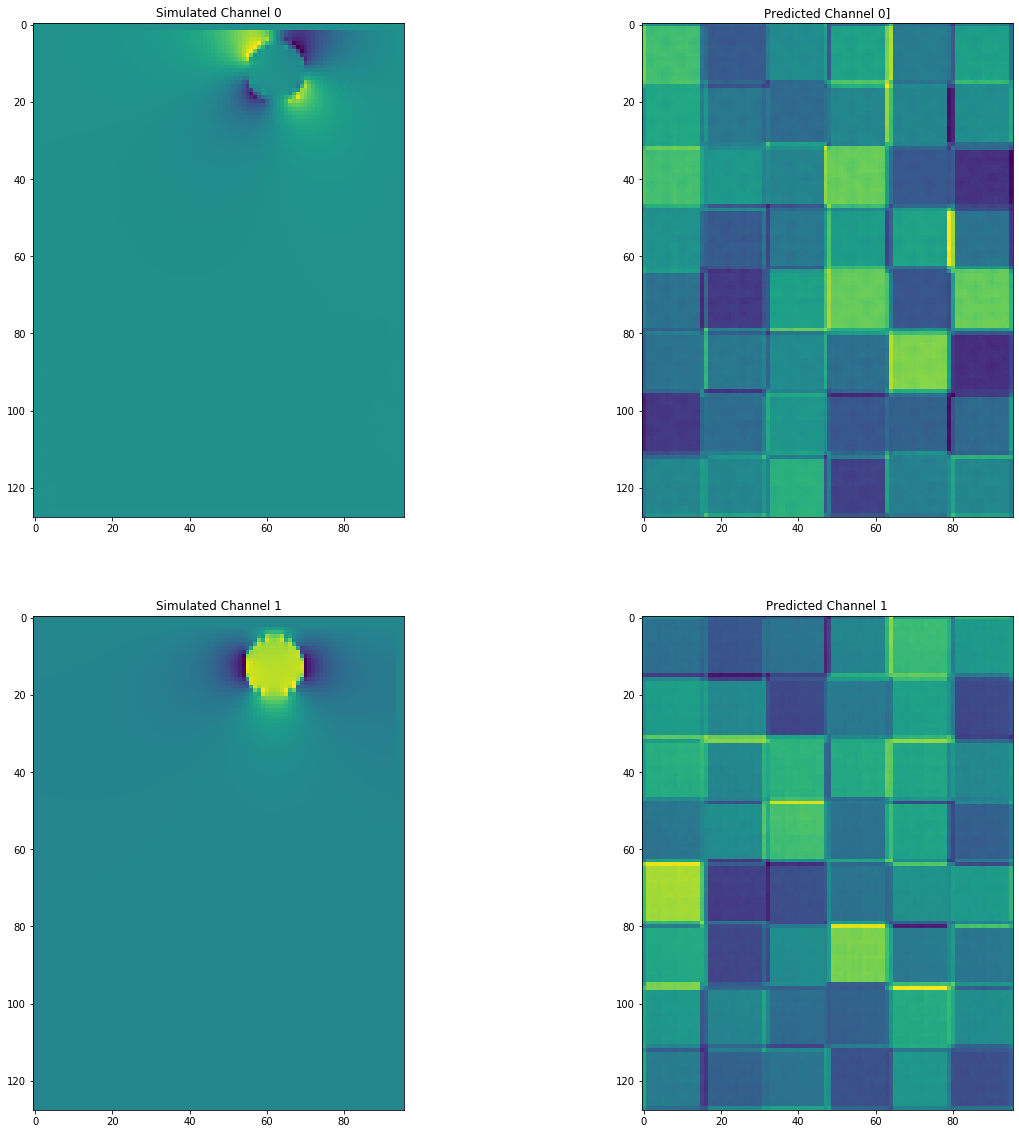

In [33]:
idx = 0 # frame in the batch 
XX = X[idx].detach().cpu().squeeze()
XX_hat = X_hat[idx].detach().cpu().squeeze()
plotSampleWpredictionByChannel(XX, XX_hat)

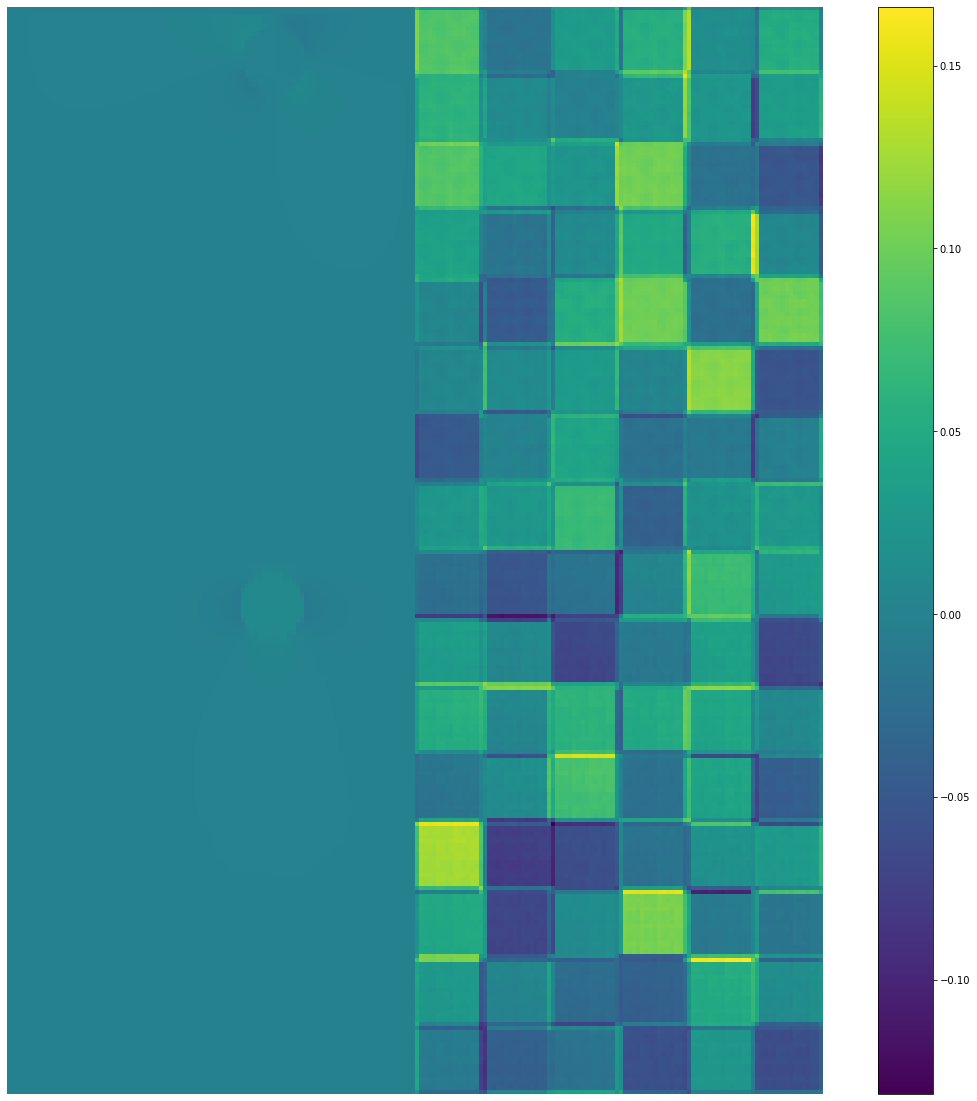

In [34]:
plotSampleWprediction(XX, XX_hat)

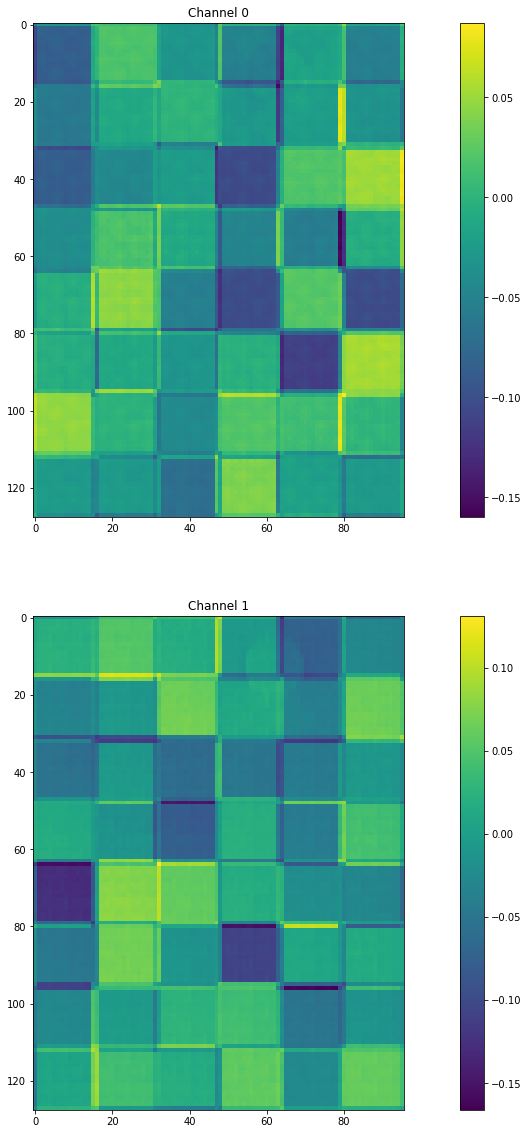

In [35]:
plotSample(XX-XX_hat)

### Visualize full simulation

In [36]:
simData = getSingleSim(sim=simVizIndex,dataDirec=testData)
simDataset = MantaFlowDataset(simData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
simDataLoader = DataLoader(simDataset,batch_size=1)

100%|██████████| 200/200 [00:00<00:00, 586.11it/s]


In [ ]:
E.eval()
G.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        
        z = E(X)
        z[:,-p.shape[1]:] = p
        X_hat = G(z)
        
        X = X.detach().cpu().squeeze()
        X_hat = X_hat.detach().cpu().squeeze()
        plotSampleWprediction(X, X_hat)



/net/10.57.1.2/vol/homes/widemann1/surrogates4sims/surrogates4sims/utils.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,20))
